In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

!pip install dowhy
import dowhy
from dowhy import CausalModel

import warnings
warnings.filterwarnings('ignore')

In [2]:
np.random.seed(42)

num_users = 10000
num_months = 12

signup_months = np.random.choice(np.arange(1, num_months), num_users) * np.random.randint(0,2, size=num_users) # signup_months == 0 means customer did not sign up
df = pd.DataFrame({
    'user_id': np.repeat(np.arange(num_users), num_months),
    'signup_month': np.repeat(signup_months, num_months), # signup month == 0 means customer did not sign up
    'month': np.tile(np.arange(1, num_months+1), num_users), # months are from 1 to 12
    'spend': np.random.poisson(500, num_users*num_months) #np.random.beta(a=2, b=5, size=num_users * num_months)*1000 # centered at 500
})
# A customer is in the treatment group if and only if they signed up
df["treatment"] = df["signup_month"]>0
# Simulating an effect of month (monotonically decreasing--customers buy less later in the year)
df["spend"] = df["spend"] - df["month"]*10
# Simulating a simple treatment effect of 100
after_signup = (df["signup_month"] < df["month"]) & (df["treatment"])
df.loc[after_signup,"spend"] = df[after_signup]["spend"] + 100
df

,user_id,signup_month,month,spend,treatment
0,0,0,1,521,False
1,0,0,2,488,False
2,0,0,3,479,False
3,0,0,4,475,False
4,0,0,5,456,False
...,...,...,...,...,...
119995,9999,2,8,541,True
119996,9999,2,9,499,True
119997,9999,2,10,518,True
119998,9999,2,11,488,True


In [3]:
i = 3

causal_graph = """digraph {
treatment[label="Program Signup in month i"];
pre_spends;
post_spends;
Z->treatment;
pre_spends -> treatment;
treatment->post_spends;
signup_month->post_spends;
signup_month->treatment;
}"""

In [4]:
df_i_signupmonth = (
    df[df.signup_month.isin([0, i])]
    .groupby(["user_id", "signup_month", "treatment"])
    .apply(
        lambda x: pd.Series(
            {
                "pre_spends": x.loc[x.month < i, "spend"].mean(),
                "post_spends": x.loc[x.month > i, "spend"].mean(),
            }
        )
    )
    .reset_index()
)
print(df_i_signupmonth)

      user_id  signup_month  treatment  pre_spends  post_spends
0           0             0      False       504.5   422.777778
1           2             0      False       485.0   434.000000
2           4             0      False       488.5   420.111111
3           5             0      False       475.0   408.333333
4           6             0      False       494.0   423.666667
...       ...           ...        ...         ...          ...
5468     9992             0      False       456.5   404.888889
5469     9993             0      False       503.0   431.888889
5470     9994             0      False       480.0   411.444444
5471     9996             0      False       453.0   406.888889
5472     9997             0      False       461.0   415.111111

[5473 rows x 5 columns]


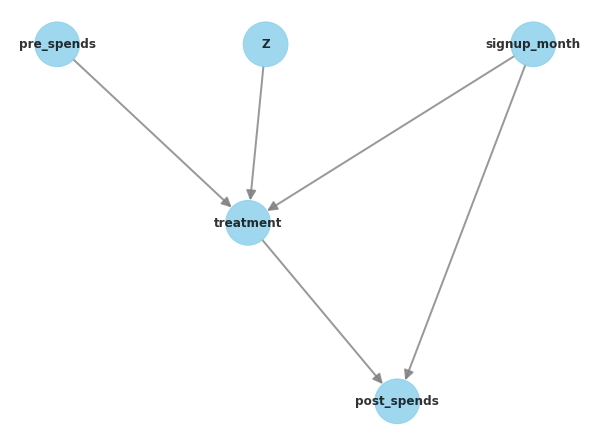

In [5]:
model = dowhy.CausalModel(data=df_i_signupmonth,
                          graph=causal_graph.replace("\n", " "),
                          treatment="treatment",
                          outcome="post_spends")
model.view_model()

In [6]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                   
────────────(E[post_spends|signup_month])
d[treatment]                             
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→post_spends then P(post_spends|treatment,signup_month,U) = P(post_spends|treatment,signup_month)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                                             -1⎤
 ⎢       d                      ⎛       d                     ⎞  ⎥
E⎢────────────────(post_spends)⋅⎜────────────────([treatment])⎟  ⎥
 ⎣d[Z  pre_spends]              ⎝d[Z  pre_spends]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→post_spends then ¬(U →→{Z,pre_spends})
Estimand assumption 2, Exclusion: If we remove {Z,pre_spends}→{treatment}, then ¬({Z,pre_spends}→post_spends)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [7]:
estimate = model.estimate_effect(identified_estimand,
                                 method_name='backdoor.propensity_score_matching',
                                 target_units='att')
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                   
────────────(E[post_spends|signup_month])
d[treatment]                             
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→post_spends then P(post_spends|treatment,signup_month,U) = P(post_spends|treatment,signup_month)

## Realized estimand
b: post_spends~treatment+signup_month
Target units: att

## Estimate
Mean value: 97.49138947865055



In [8]:
refutation = model.refute_estimate(identified_estimand, estimate, method_name='placebo_treatment_refuter',
                     placebo_type='permute', num_simulations=20)
print(refutation)

Refute: Use a Placebo Treatment
Estimated effect:97.49138947865055
New effect:-3.122080679405515
p value:0.14662574517912463

